# Named Entity Recognition

Named-entity recognition (NER) is a problem that has a goal to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, etc.

File ner_dataset.csv maps sentence number (Sentence #) to first word (Word) of respective sentence. Then each word is mapped to its respective POS tag (POS) and NER tag (Tag). Ignore the POS tag column for scope of this case-study. For every sentence just consider the word and its NER tag.

In [16]:
import pandas as pd
import numpy as np
import chardet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import logging
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
logger = logging.basicConfig()
seed = 421

# Imput dataset

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
ls drive/MyDrive

'Colab Notebooks'/          'Machine Learning'/   Resume/
 Document/                   Narasimha/           Songs/
 Family/                     ner_dataset.csv      SudhirKumar-DataScientist-1Page-Resume.pdf
 FY2023-24/                  Nisha/
 github-recovery-codes.txt   Resolution/


In [19]:
file = 'drive/MyDrive/ner_dataset.csv'
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}

In [20]:
# Load the dataset
data = pd.read_csv(file,encoding='latin-1')
print(f'Number of rows and columns {data.shape}')
data.head()

Number of rows and columns (1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [21]:
data.count()

Sentence #      47959
Word          1048565
POS           1048575
Tag           1048575
dtype: int64

## Data Preprocessing

In [22]:
# preprocess the data
data['Sentence #'] = data['Sentence #'].fillna(method='ffill')

In [23]:
data.isnull().sum()

Sentence #     0
Word          10
POS            0
Tag            0
dtype: int64

In [24]:
data[data['Word'].isnull()]

,Sentence #,Word,POS,Tag
197658,Sentence: 9047,NaN,NN,O
256026,Sentence: 11709,NaN,NN,O
257069,Sentence: 11759,NaN,NN,O
571211,Sentence: 26129,NaN,NN,O
613777,Sentence: 28049,NaN,NN,O
747019,Sentence: 34152,NaN,NN,O
901758,Sentence: 41181,NaN,NN,O
903054,Sentence: 41244,NaN,NN,O
944880,Sentence: 43177,NaN,NN,O
1003438,Sentence: 45887,NaN,NN,O


In [25]:
data[data["Sentence #"]== "Sentence: 11709"]

,Sentence #,Word,POS,Tag
256026,Sentence: 11709,NaN,NN,O
256027,Sentence: 11709,of,IN,O
256028,Sentence: 11709,the,DT,O
256029,Sentence: 11709,injuries,NNS,O
256030,Sentence: 11709,was,VBD,O
256031,Sentence: 11709,serious,JJ,O
256032,Sentence: 11709,.,.,O


In [26]:
# drop sentence with na value
# data = data.dropna()
na_sentence = data.loc[data['Word'].isnull(),"Sentence #"].unique()
data = data[~data["Sentence #"].isin(na_sentence)]

data.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [27]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 17


Tag
O        887788
B-geo     37643
B-tim     20331
B-org     20142
I-per     17251
B-per     16990
I-org     16783
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [28]:
data.query("Tag == 'I-nat' ").head()

,Sentence #,Word,POS,Tag
5045,Sentence: 227,Jing,NNP,I-nat
5074,Sentence: 229,Jing,NNP,I-nat
12509,Sentence: 568,Acute,NNP,I-nat
12510,Sentence: 568,Respiratory,NNP,I-nat
12511,Sentence: 568,Syndrome,NNP,I-nat


In [29]:
# lets look at the sentence
data[data["Sentence #"]== "Sentence: 227"]

,Sentence #,Word,POS,Tag
5032,Sentence: 227,One,CD,O
5033,Sentence: 227,of,IN,O
5034,Sentence: 227,the,DT,O
5035,Sentence: 227,2008,CD,B-eve
5036,Sentence: 227,Olympic,JJ,I-eve
5037,Sentence: 227,mascots,NNS,O
5038,Sentence: 227,is,VBZ,O
5039,Sentence: 227,modeled,VBN,O
5040,Sentence: 227,on,IN,O
5041,Sentence: 227,a,DT,O


In [30]:
data.query("Tag == 'B-nat' ").head()

,Sentence #,Word,POS,Tag
2723,Sentence: 121,H5N1,NNP,B-nat
4554,Sentence: 206,H5N1,NNP,B-nat
5044,Sentence: 227,Jing,NNP,B-nat
5073,Sentence: 229,Jing,NNP,B-nat
5606,Sentence: 255,H5N1,NNP,B-nat


In [31]:
data.query("Tag == 'I-art' ").head()

,Sentence #,Word,POS,Tag
264,Sentence: 12,Non-Proliferation,NNP,I-art
3811,Sentence: 171,V-6,NNP,I-art
4016,Sentence: 183,Simple,NNP,I-art
4017,Sentence: 183,Life,NNP,I-art
4142,Sentence: 188,Morning,NNP,I-art


In [32]:
data.query("Tag == 'B-art' ").head()

,Sentence #,Word,POS,Tag
263,Sentence: 12,Nuclear,NNP,B-art
3769,Sentence: 169,Saltillo,NNP,B-art
3810,Sentence: 171,Pentastar,NNP,B-art
3814,Sentence: 171,Chrysler,NNP,B-art
3816,Sentence: 171,Dodge,NNP,B-art


In [33]:
data.query("Tag == 'I-eve' ").head()

,Sentence #,Word,POS,Tag
4854,Sentence: 219,Summer,NNP,I-eve
4855,Sentence: 219,Olympics,NNPS,I-eve
5036,Sentence: 227,Olympic,JJ,I-eve
5171,Sentence: 234,Medusa,NNP,I-eve
5764,Sentence: 262,War,NNP,I-eve


In [34]:
data.query("Tag == 'B-eve' ").head()

,Sentence #,Word,POS,Tag
4853,Sentence: 219,2012,CD,B-eve
4887,Sentence: 220,Games,NNPS,B-eve
5001,Sentence: 224,Games,NNPS,B-eve
5035,Sentence: 227,2008,CD,B-eve
5170,Sentence: 234,Operation,NNP,B-eve


In [35]:
# Tags are with fewer counts
# we will drop these tags
entities_to_remove = ["B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"]
# data = data[~data.Tag.isin(entities_to_remove)]
ent_sentence = data.loc[data['Tag'].isin(entities_to_remove),"Sentence #"].unique()
print(f'Number sentence will drop {len(ent_sentence)}')
data = data[~data["Sentence #"].isin(ent_sentence)].reset_index(drop=True)

data.head()

Number sentence will drop 798


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [36]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 11


Tag
O        871963
B-geo     37038
B-tim     19928
B-org     19806
I-per     16974
B-per     16689
I-org     16544
B-gpe     15656
I-geo      7268
I-tim      6341
I-gpe       192
Name: count, dtype: int64

In [37]:
# remove white space
data['Word'] = data['Word'].str.strip()

In [38]:
def preprocess_fn(data):
    # preprocess the data
    data['Sentence #'] = data['Sentence #'].fillna(method='ffill')

    # drop sentence with na value
    # data = data.dropna()
    na_sentence = data.loc[data['Word'].isnull(),"Sentence #"].unique()
    data = data[~data["Sentence #"].isin(na_sentence)]
    print('Missing values\n',data.isnull().sum())

    # Tags are with fewer counts
    # we will drop these tags
    entities_to_remove = ["B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"]
    # data = data[~data.Tag.isin(entities_to_remove)]
    ent_sentence = data.loc[data['Tag'].isin(entities_to_remove),"Sentence #"].unique()
    print(f'Number sentence will drop {len(ent_sentence)}')
    data = data[~data["Sentence #"].isin(ent_sentence)].reset_index(drop=True)

    # remove white space
    data['Word'] = data['Word'].str.strip()

    return data

In [39]:
_ = preprocess_fn(data)

Missing values
 Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64
Number sentence will drop 0


# Naive Bayes Model

In [40]:
# Split into train, validation, and test sets
train_sent, test_sent, train_tag, test_tag = train_test_split(
    data['Word'], data['Tag'],
    stratify=data['Tag'],
    # shuffle=True,
    test_size=0.2, random_state=seed)
train_sent, val_sent, train_tag, val_tag = train_test_split(
    train_sent, train_tag,
    stratify=train_tag,
    # shuffle=True,
    test_size=0.2, random_state=seed)

In [41]:
vectorizer = TfidfVectorizer(max_features=10000)
train_features = vectorizer.fit_transform(train_sent)
val_features = vectorizer.transform(val_sent)
test_features = vectorizer.transform(test_sent)

In [42]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_tag)
val_labels_encoded = label_encoder.transform(val_tag)
test_labels_encoded = label_encoder.transform(test_tag)

In [43]:
# Train a Logistic Regression model
# model = LogisticRegression(max_iter=1000)
model = MultinomialNB()
model.fit(train_features, train_labels_encoded)

# Evaluate the model
val_predictions = model.predict(val_features)
print(classification_report(val_labels_encoded, val_predictions, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       B-geo       0.78      0.72      0.75      5926
       B-gpe       0.94      0.93      0.94      2505
       B-org       0.79      0.32      0.46      3169
       B-per       0.75      0.57      0.65      2670
       B-tim       0.87      0.73      0.79      3188
       I-geo       0.79      0.39      0.52      1163
       I-gpe       0.00      0.00      0.00        31
       I-org       0.68      0.12      0.20      2647
       I-per       0.73      0.60      0.66      2716
       I-tim       0.76      0.02      0.03      1015
           O       0.94      1.00      0.97    139514

    accuracy                           0.93    164544
   macro avg       0.73      0.49      0.54    164544
weighted avg       0.92      0.93      0.92    164544



# BERT Model

BERT (Bidirectional Encoder Representations from Transformers) is a neural network that is capable of parsing language in the same way a human does. It uses word embeddings to translate words into numbers and then back again, allowing it to understand word context and meaning.

In [44]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import string

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [45]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [46]:
# Encode labels
label_encoder = LabelEncoder()
data['Tag'] = label_encoder.fit_transform(data['Tag'])

In [47]:
# sentences = data.groupby('Sentence #')['Word'].apply(list).values
# tags = data.groupby('Sentence #')['Tag'].apply(list).values
#Group By Sentences
data_gr = data.groupby("Sentence #").agg({'Word': list, 'POS':list, 'Tag':list})
data_gr.head()

,Word,POS,Tag
Sentence #,,,
Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10..."
Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."
Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[10, 10, 4, 10, 10, 10, 10, 10, 0, 10, 10, 10,..."
Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]"
Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[0, 10, 10, 3, 8, 10, 4, 10, 0, 10, 1, 10, 1, ..."


In [48]:
data_gr['no_word'] = data_gr['Word'].apply(lambda x: len(x))


[Text(0.5, 1.0, 'Number of words in sentence'), Text(0.5, 0, 'Number of Word')]

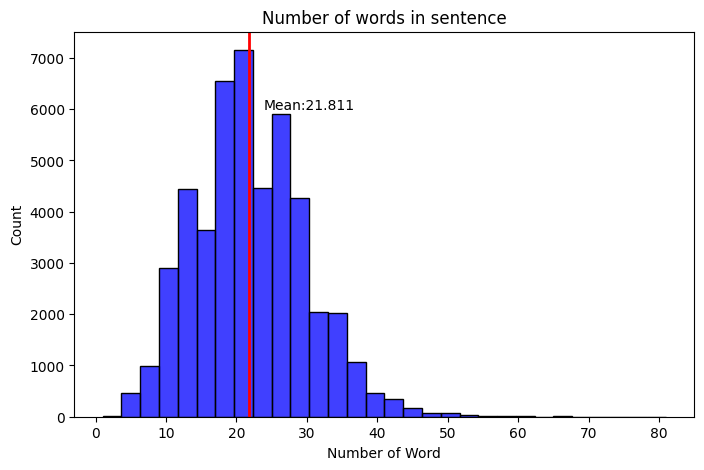

In [49]:
f,ax = plt.subplots(figsize=(8,5))
mean = round(data_gr['no_word'].mean(),3)
sns.histplot(data_gr['no_word'], color='Blue', bins=30)
ax.axvline(mean,ymax=5000,linewidth=2,color='red')
ax.text(mean+2,6000,s=f'Mean:{mean}')
plt.setp(ax,title='Number of words in sentence',xlabel='Number of Word')

In [50]:
# Split into train, validation, and test sets
train_sent, test_sent, train_tag, test_tag = train_test_split(
    data_gr['Word'], data_gr['Tag'],
    # stratify=data_gr['Tag'],
    # shuffle=True,
    test_size=0.2, random_state=seed)
train_sent, val_sent, train_tag, val_tag = train_test_split(
    train_sent, train_tag,
    # stratify=train_tag,
    # shuffle=True,
    test_size=0.2, random_state=seed)

In [51]:
CLS = [101]
SEP = [102]
VALUE_TOKEN = [0]
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 8
EPOCHS = 3
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Dataset

In [52]:
class Dataset:

    def __init__(self,text,tags):
        self.text = text
        self.tags = tags

    def __len__(self):
        return len(self.text)

    def __getitem__(self,index):
        text = self.text[index]
        tags = self.tags[index]

        # tokenize
        ids = []
        target_tags = []
        for i,s in enumerate(text):

            inputs = TOKENIZER.encode(s,add_special_tokens=False)

            input_len = len(inputs)
            ids.extend(inputs)
            target_tags.extend(input_len * [tags[i]])

        #Add Sepcial Tokens
        ids = CLS + ids + SEP
        target_tags = VALUE_TOKEN + target_tags + VALUE_TOKEN

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        #Add Padding if the input_len is small
        padding_len = MAX_LEN - len(ids)
        ids = ids + ([0] * padding_len)
        target_tags = target_tags + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)

        res = {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask" : torch.tensor(mask, dtype=torch.long),
            "token_type_ids" : torch.tensor(token_type_ids, dtype=torch.long),
            "target_tags" : torch.tensor(target_tags, dtype=torch.long)
        }

        return res

In [53]:
#Create DataLoaders
train_dataset = Dataset(text = train_sent, tags = train_tag)
val_dataset = Dataset(text = val_sent, tags = val_tag)
train_data_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE)
val_data_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE)

In [54]:
for data_ in train_data_loader:
    print(data_)
    break

{'ids': tensor([[ 101,  100, 2560,  ...,    0,    0,    0],
        [ 101,  100, 2360,  ...,    0,    0,    0],
        [ 101,  100, 2001,  ...,    0,    0,    0],
        ...,
        [ 101,  100,  100,  ...,    0,    0,    0],
        [ 101,  100, 2048,  ...,    0,    0,    0],
        [ 101,  100, 1997,  ...,    0,    0,    0]]), 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'target_tags': tensor([[ 0, 10, 10,  ...,  0,  0,  0],
        [ 0, 10, 10,  ...,  0,  0,  0],
        [ 0, 10, 10,  ...,  0,  0,  0],
        ...,
        [ 0, 10,  2,  ...,  0,  0,  0],
        [ 0, 

## NERBertModel

In [48]:
class NERBertModel(nn.Module):

    def __init__(self,num_tag):
        super(NERBertModel,self).__init__()
        self.num_tag = num_tag
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_drop = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768,self.num_tag)

    def forward(self,ids,mask,token_type_ids,target_tags):
        output, _ = self.bert(ids,attention_mask=mask,
                              token_type_ids=token_type_ids,return_dict=False)
        bert_out = self.bert_drop(output)
        tag = self.out_tag(bert_out)

        return tag

In [ ]:
def train_fn(train_data_loader,model,optimizer,device,scheduler):
    # Train the model
    model.train()
    loss_ = 0
    for data in tqdm(train_data_loader,total=len(train_data_loader)):
        for i, j in data.item():
            data[i] = j.to(DEVICE)

        # Back propagation
        optimizer.zero_grad()
        tag = model(**data)

        # loss
        loss = critirion(data['target_tag'])

In [61]:
def train_fn(train_data_loader, model, optimizer, device):
    #Train the Model
    model.train()
    loss_ = 0
    for data in tqdm(train_data_loader, total = len(train_data_loader)):
        for i, j in data.items():
            data[i] = j.to(device)

        #Backward Propagation
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        loss_ += loss.item()
    return model, loss_ / len(train_data_loader)

def val_fn(val_data_loader, model, optimizer, device):
    model.eval()
    loss_ = 0
    for data in tqdm(val_data_loader, total = len(val_data_loader)):
        for i, j in data.items():
            data[i] = j.to(device)
        _, loss = model(**data)
        loss_ += loss.item()
    return loss_ / len(val_data_loader)

In [62]:
class NERBertModel(nn.Module):

    def __init__(self, num_tag):
        super(NERBertModel, self).__init__()
        self.num_tag = num_tag
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_drop = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, self.num_tag)

    def forward(self, ids, mask, token_type_ids, target_tags):
        output, _ = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        bert_out = self.bert_drop(output)
        tag = self.out_tag(bert_out)

        #Calculate the loss
        Critirion_Loss = nn.CrossEntropyLoss()
        active_loss = mask.view(-1) == 1
        active_logits = tag.view(-1, self.num_tag)
        active_labels = torch.where(active_loss, target_tags.view(-1), torch.tensor(Critirion_Loss.ignore_index).type_as(target_tags))
        loss = Critirion_Loss(active_logits, active_labels)
        return tag, loss

## Train Model

In [63]:
#Model Architecture
num_tag = len(data.Tag.value_counts())
model = NERBertModel(num_tag=num_tag)
model.to(DEVICE)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=3e-5)
num_train_steps = int(len(train_sent) / TRAIN_BATCH_SIZE * EPOCHS)
print(model)

NERBertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [67]:
for epoch in range(EPOCHS):
    model, train_loss = train_fn(train_data_loader, model, optimizer, DEVICE)
    val_loss = val_fn(val_data_loader, model, optimizer, DEVICE)
    print(f"Epoch: {epoch + 1}, Train_loss: {train_loss}, Val_loss: {val_loss}")

100%|██████████| 943/943 [01:01<00:00, 15.26it/s]


Epoch: 1, Train_loss: 0.2259085635918322, Val_loss: 0.1574284144354271


100%|██████████| 943/943 [01:01<00:00, 15.27it/s]


Epoch: 2, Train_loss: 0.1479071482921203, Val_loss: 0.1508893652662066


100%|██████████| 943/943 [01:01<00:00, 15.33it/s]

Epoch: 3, Train_loss: 0.12371442150146812, Val_loss: 0.1534281996200266


In [68]:
def prediction(test_sentence, model, le):
    for i in list(string.punctuation):
        test_sentence = test_sentence.replace(i, ' ' + i)
    test_sentence = test_sentence.split()
    print(test_sentence)
    Token_inputs = TOKENIZER.encode(test_sentence, add_special_tokens=False)
    print(Token_inputs)
    test_dataset =  Dataset(test_sentence, tags= [[1] * len(test_sentence)])
    num_tag = len(le.classes_)

    with torch.no_grad():
        data = test_dataset[0]
        for i, j in data.items():
            data[i] = j.to(DEVICE).unsqueeze(0)
        tag, _ = model(**data)

        print(le.inverse_transform(tag.argmax(2).cpu().numpy().reshape(-1))[1:len(Token_inputs)+1])

In [69]:
test_sentence = "Charles I was born in Fife on 19 November 1600."
prediction(test_sentence, model, label_encoder)

['Charles', 'I', 'was', 'born', 'in', 'Fife', 'on', '19', 'November', '1600', '.']
[100, 100, 2001, 2141, 1999, 100, 2006, 2539, 100, 14883, 1012]
['O' 'I-per' 'O' 'O' 'O' 'B-per' 'I-per' 'B-geo' 'O' 'O' 'O']


In [70]:
test_sentence = "Dogs are the most variable mammal on earth with around 450 globally recognized dog breeds."
prediction(test_sentence, model, label_encoder)

['Dogs', 'are', 'the', 'most', 'variable', 'mammal', 'on', 'earth', 'with', 'around', '450', 'globally', 'recognized', 'dog', 'breeds', '.']
[100, 2024, 1996, 2087, 8023, 25476, 2006, 3011, 2007, 2105, 10332, 16452, 3858, 3899, 15910, 1012]
['O' 'O' 'I-per' 'I-per' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O']


In [72]:
torch.save(model.state_dict(), "drive/MyDrive/model.bin")

# Inference

In [1]:
def inference_fn(mode,text):
    pass